In [ ]:
#Importing ALl important libraries

import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as Mimg
from PIL import Image
%matplotlib inline
import re
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten, Dropout
from tensorflow.keras import layers, models
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.applications import DenseNet121
import PIL.Image as Image
from keras.preprocessing import image

Tensorflow version 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rarfile
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [ ]:
import rarfile

rar_file_path = '/content/drive/MyDrive/Plant_disease/Plant_disease_dataset-20240528T044506Z-001.rar'

local_extract_path = '/content/Extracted_files'

os.makedirs(local_extract_path, exist_ok=True)

with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall(local_extract_path)

extracted_files = os.listdir(local_extract_path)
print(f'Extracted files and directories: {extracted_files}')

for data in extracted_files:
  data_path = os.path.join(local_extract_path + '/' + data)

data_path

Extracted files and directories: ['Plant_disease_dataset']


'/content/Extracted_files/Plant_disease_dataset'

In [ ]:
# Importing all paths
import pathlib
data_path = '/content/Extracted_files/Plant_disease_dataset'
train_path = '/content/Extracted_files/Plant_disease_dataset/Train'
valid_path = '/content/Extracted_files/Plant_disease_dataset/Validation'

In [ ]:
print (os.listdir(data_path))

['Train', 'Test', 'Validation']


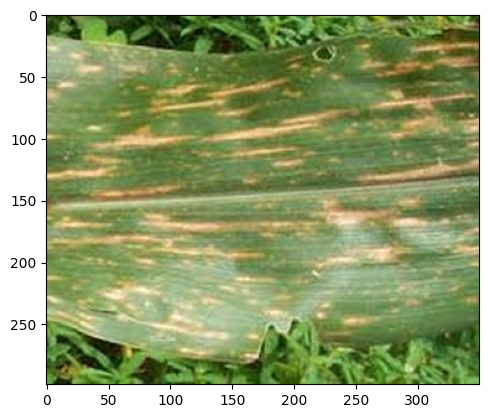

In [ ]:
#Example Image
img = Mimg.imread('/content/Extracted_files/Plant_disease_dataset/Validation/Corn_Gray_Leaf_Spot/Corn_Gray_Spot (11).jpg')
plt.imshow(img)
plt.show()

In [ ]:
# Seeding the dataset with default value 123
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 15447 files belonging to 3 classes.


In [ ]:
data_dir = pathlib.Path(data_path)

In [ ]:
# Creating filepaths and labels
filepaths = list(data_dir.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Creating dataframe
dataframe = pd.concat([filepaths, labels], axis=1)

In [ ]:
dataframe

Filepath        Label
0     /content/Extracted_files/Plant_disease_dataset...   Rice_Blast
1     /content/Extracted_files/Plant_disease_dataset...   Rice_Blast
2     /content/Extracted_files/Plant_disease_dataset...   Rice_Blast
3     /content/Extracted_files/Plant_disease_dataset...   Rice_Blast
4     /content/Extracted_files/Plant_disease_dataset...   Rice_Blast
...                                                 ...          ...
3581  /content/Extracted_files/Plant_disease_dataset...  Rice_Tungro
3582  /content/Extracted_files/Plant_disease_dataset...  Rice_Tungro
3583  /content/Extracted_files/Plant_disease_dataset...  Rice_Tungro
3584  /content/Extracted_files/Plant_disease_dataset...  Rice_Tungro
3585  /content/Extracted_files/Plant_disease_dataset...  Rice_Tungro

[3586 rows x 2 columns]

In [ ]:
# Using Image data generator and applying preporcessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.08)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_path,
                                               target_size = (256,256),
                                               batch_size = 64,
                                               shuffle = True,
                                               class_mode = "categorical",
                                             subset='training')

valid_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = (256,256),
                                                    batch_size = 64,
                                                    shuffle = True,
                                                    class_mode = "categorical",
                                                    subset='validation')

test_generator = validation_datagen.flow_from_directory(valid_path,
                                                        batch_size=64,
                                                        shuffle = False,
                                                        class_mode='categorical',
                                                        target_size=(256,256))

Found 12460 images belonging to 28 classes.
Found 1070 images belonging to 28 classes.
Found 1917 images belonging to 28 classes.


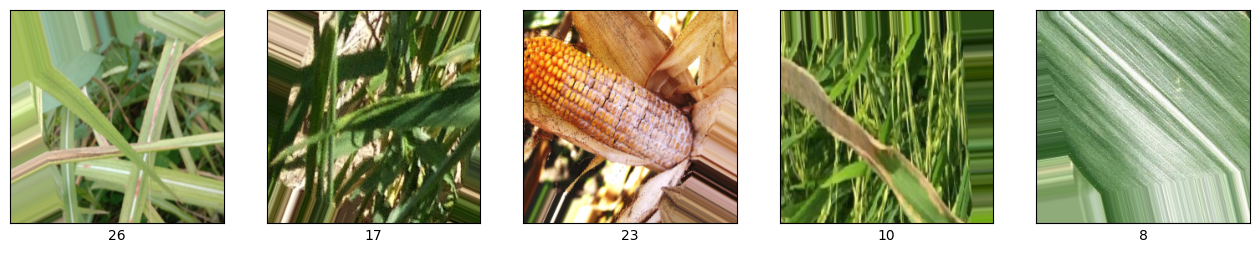

In [ ]:
# Importing image examples after preprocessing
from tensorflow.keras.preprocessing import image
sample_x, sample_y = next(train_generator)
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = image.img_to_array(sample_x[i])
    plt.imshow(img)
    plt.xlabel(np.argmax(sample_y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# classes in generator fucntion
print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

{'Corn_Common_Rust': 0, 'Corn_Gray_Leaf_Spot': 1, 'Corn_Leaf_smut': 2, 'Cotton_American_Bollworm': 3, 'Cotton_Aphid': 4, 'Cotton_Healthy': 5, 'Cotton_bacterial_blight': 6, 'Cotton_bollrot': 7, 'Maize_Healthy': 8, 'Maize_stem_borer': 9, 'Rice_Bacterial Blight': 10, 'Rice_Blast': 11, 'Rice_Brownspot': 12, 'Rice_Tungro': 13, 'Sugarcane_Healthy': 14, 'Sugarcane_Yellow_Rust': 15, 'Wheat_Brown_leaf_Rust': 16, 'Wheat_Healthy': 17, 'Wheat_Yellow_Rust': 18, 'Wheat_aphid': 19, 'Wheat_leaf_blight': 20, 'Wheat_powdery_mildew': 21, 'cotton_whitefly': 22, 'maize_ear_rot': 23, 'maize_fall_armyworm': 24, 'sugarcane_Mosaic': 25, 'sugarcane_RedRot': 26, 'sugarcane_RedRust': 27}
{'Corn_Common_Rust': 0, 'Corn_Gray_Leaf_Spot': 1, 'Corn_Leaf_smut': 2, 'Cotton_American_Bollworm': 3, 'Cotton_Aphid': 4, 'Cotton_Healthy': 5, 'Cotton_bacterial_blight': 6, 'Cotton_bollrot': 7, 'Maize_Healthy': 8, 'Maize_stem_borer': 9, 'Rice_Bacterial Blight': 10, 'Rice_Blast': 11, 'Rice_Brownspot': 12, 'Rice_Tungro': 13, 'Sugarc

In [ ]:
# creating tensorflow model using ResNet152V2 model
import tensorflow
# base_model =tensorflow.keras.applications.ResNet152V2(input_shape=(256,256,3), weights='imagenet', include_top=False)
base_model =tensorflow.keras.applications.ResNet152V2(input_shape=(256,256,3), weights='imagenet', include_top=False)

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
# Model Summary
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [ ]:
base_model.trainable=False
# Freeze four convolution blocks
for layer in base_model.layers[557:]:
    layer.trainable = True
# Make sure we have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
flatten_layer = Flatten()(base_model.output)

prediction_layer =layers.Dense(28, activation='softmax')(flatten_layer)

#creating model
model = Model(inputs=base_model.input, outputs=prediction_layer)

In [ ]:
# using optimizer
Adam = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
model.compile(optimizer = Adam , loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience= 2,factor=0.2, verbose=1)
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=3,  restore_best_weights=True)
mc = ModelCheckpoint('ResNet152V2_model.h5' , save_weights_only=True, save_best_only=True, verbose=1)
callback = [es,mc,red_lr]
5
history = model.fit_generator (train_generator,  epochs=15, validation_data=valid_generator, callbacks= callback)

Epoch 1/15
195/195 [==============================] - ETA: 0s - loss: 1.9718 - accuracy: 0.4848
Epoch 1: val_loss improved from inf to 1.29900, saving model to ResNet152V2_model.h5
195/195 [==============================] - 338s 2s/step - loss: 1.9718 - accuracy: 0.4848 - val_loss: 1.2990 - val_accuracy: 0.6551 - lr: 1.0000e-05
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.7181
Epoch 2: val_loss improved from 1.29900 to 0.97594, saving model to ResNet152V2_model.h5
195/195 [==============================] - 319s 2s/step - loss: 0.9676 - accuracy: 0.7181 - val_loss: 0.9759 - val_accuracy: 0.7178 - lr: 1.0000e-05
Epoch 3/15
195/195 [==============================] - ETA: 0s - loss: 0.7188 - accuracy: 0.7812
Epoch 3: val_loss improved from 0.97594 to 0.81408, saving model to ResNet152V2_model.h5
195/195 [==============================] - 319s 2s/step - loss: 0.7188 - accuracy: 0.7812 - val_loss: 0.8141 - val_accuracy: 0.7720 - lr: 1.0000e-05
Ep

In [ ]:
from tensorflow.keras.models import load_model
model.save('ResNet152V2_model.h5')

In [ ]:
history.history['val_accuracy']

[0.6551401615142822,
 0.717756986618042,
 0.7719626426696777,
 0.7878504395484924,
 0.7953271269798279,
 0.822429895401001,
 0.8112149238586426,
 0.8373831510543823,
 0.8467289805412292,
 0.8579439520835876,
 0.8542056083679199,
 0.8654205799102783,
 0.8850467205047607,
 0.8878504633903503,
 0.8785046935081482]

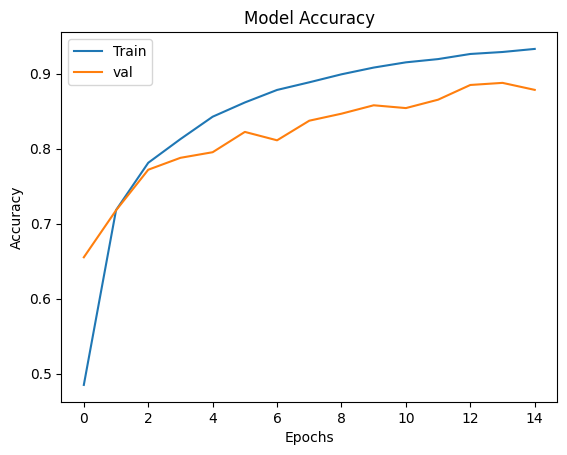

In [ ]:
#Plotting the graph for model accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

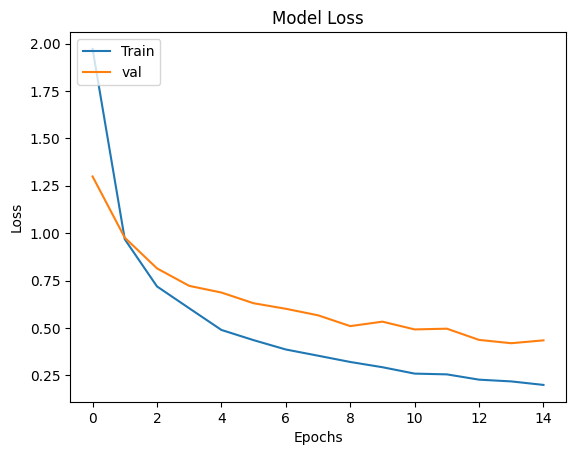

In [ ]:
#Plotting the graph for model loss
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [ ]:
import pickle
pickle.dump(model,open('Plant_disease_classification.pkl','wb'))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/ResNet152V2_model.h5')

In [ ]:
scores = model.evaluate(test_generator)

30/30 [==============================] - 89s 3s/step - loss: 0.9162 - accuracy: 0.7939


In [ ]:
y_pred = model.predict(test_generator)

30/30 [==============================] - 93s 3s/step


In [ ]:
L = ['Corn_Common_Rust', 'Corn_Gray_Leaf_Spot', 'Corn_Leaf_smut', 'Cotton_American_Bollworm', 'Cotton_Aphid', 'Cotton_Healthy', 'Cotton_bacterial_blight', 'Cotton_bollrot', 'Maize_Healthy', 'Maize_stem_borer', 'Rice_Bacterial Blight', 'Rice_Blast', 'Rice_Brownspot', 'Rice_Tungro', 'Sugarcane_Healthy', 'Sugarcane_Yellow_Rust', 'Wheat_Brown_leaf_Rust', 'Wheat_Healthy', 'Wheat_Yellow_Rust', 'Wheat_aphid', 'Wheat_leaf_blight', 'Wheat_powdery_mildew', 'cotton_whitefly', 'maize_ear_rot', 'maize_fall_armyworm', 'sugarcane_Mosaic', 'sugarcane_RedRot', 'sugarcane_RedRust' ]

In [ ]:
img= '/content/Extracted_files/Plant_disease_dataset/Validation/Cotton_Aphid/1 (2).jpg'

In [ ]:
import cv2

In [ ]:
# disease prediction function
def predict_disease(test_image):
    img = cv2.imread(test_image)
    img = img / 255.0
    img = cv2.resize(img, (256, 256))
    img = img.reshape(1,256,256,3)
    prediction = model.predict(img)
    pred_class = np.argmax(prediction, axis = -1)
    return pred_class

In [ ]:
pred=predict_disease(img)
d=pred[0]

1/1 [==============================] - 3s 3s/step


In [ ]:
L[d]

'Cotton_bacterial_blight'

1/1 [==============================] - 0s 199ms/step


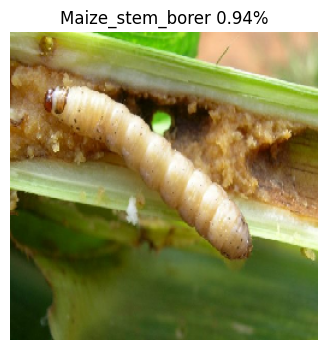

1/1 [==============================] - 0s 196ms/step


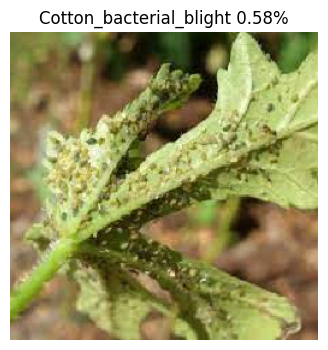

1/1 [==============================] - 0s 193ms/step


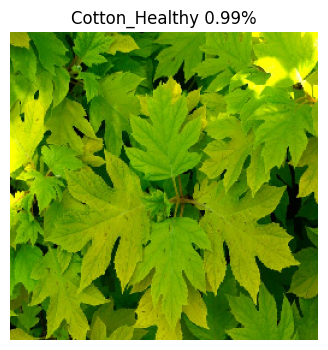

1/1 [==============================] - 0s 192ms/step


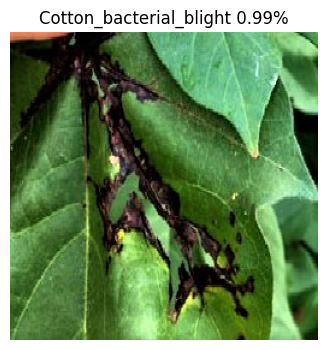

1/1 [==============================] - 0s 196ms/step


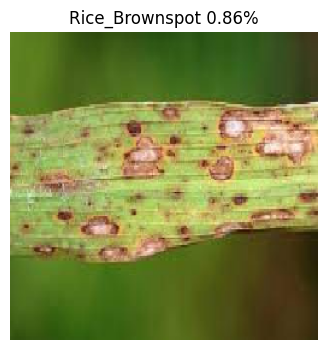

1/1 [==============================] - 0s 195ms/step


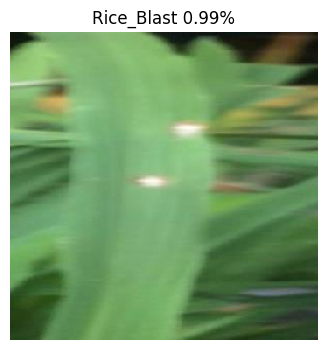

1/1 [==============================] - 0s 195ms/step


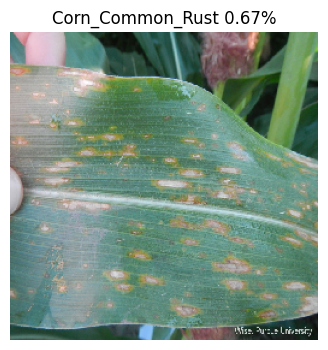

1/1 [==============================] - 0s 195ms/step


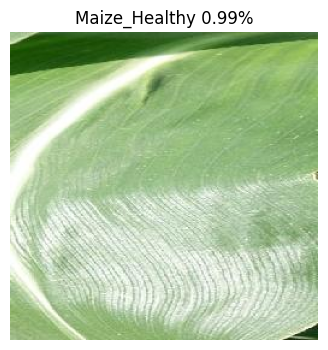

1/1 [==============================] - 0s 192ms/step


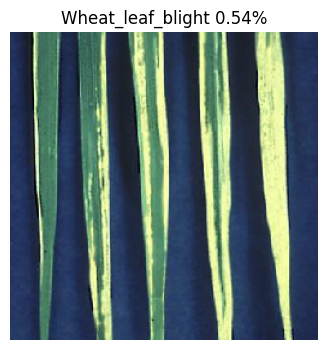

1/1 [==============================] - 0s 193ms/step


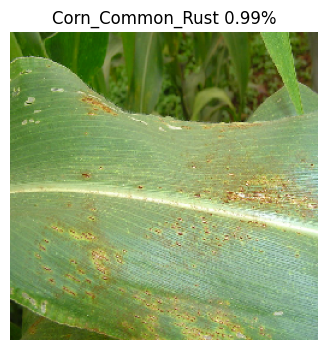

1/1 [==============================] - 0s 196ms/step


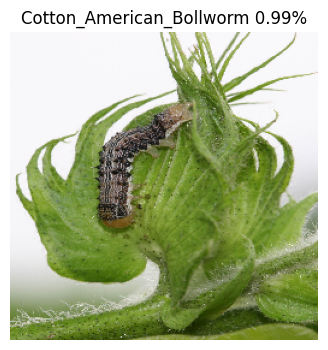

1/1 [==============================] - 0s 197ms/step


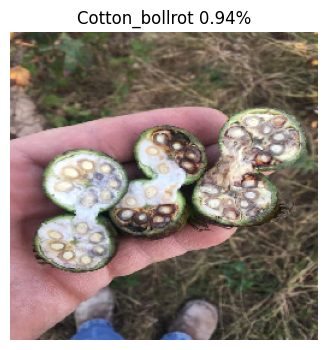

1/1 [==============================] - 0s 193ms/step


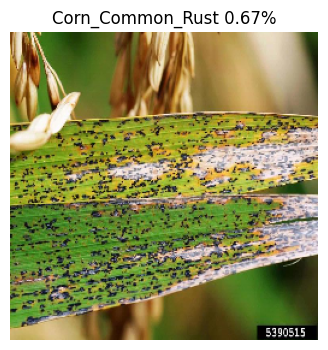

1/1 [==============================] - 0s 197ms/step


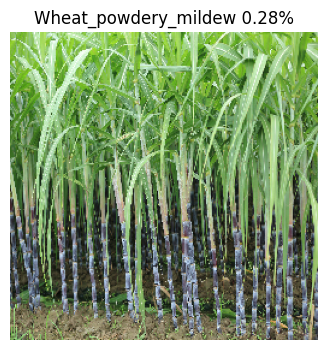

1/1 [==============================] - 0s 196ms/step


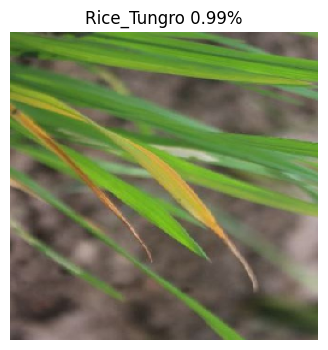

1/1 [==============================] - 0s 194ms/step


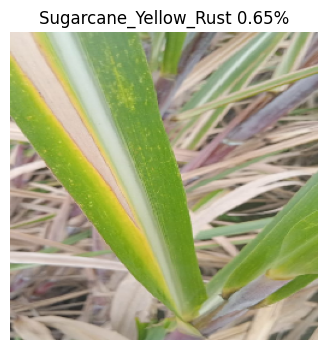

In [ ]:
#printing the predicted images

import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory= '/content/Extracted_files/Plant_disease_dataset/Test'
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
for i in range(0,16):
    image_path = files[i]
    new_img =keras.utils.load_img(image_path, target_size=(256, 256))
    img = keras.utils.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = model.predict(img)
    probabilty = prediction.flatten()
    max_prob = probabilty.max()
    index=prediction.argmax(axis=-1)[0]
    class_name = L[index]
    #ploting image with predicted class name
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
    plt.show()